<a href="https://www.kaggle.com/code/niltonpegass/yellow-taxi-regression-fare-predict?scriptVersionId=241811635" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [26]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from scipy import stats

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from xgboost import plot_importance
import sklearn.metrics as metrics

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

df = pd.read_csv('/kaggle/input/new-york-city-taxi-trips-2017/2017_Yellow_Taxi_Trip_Data.csv')

In [27]:
def display_dataset_overview(df: pd.DataFrame) -> None:
    """
    Display general information about the dataset,
    including shape, variable descriptions, sample data, and summary statistics.
    """
    print(
        f">> Dataset shape: {df.shape[0]} rows and {df.shape[1]} columns "
        f"({df.shape[0] * df.shape[1]} data points)\n"
    )

    # Description of key dataset variables
    variable_descriptions = {
        'ab': "ab",
        'ab': "ab",
        'ab': "ab",
        'ab': "ab",
        'ab': "ab",
        'ab': "ab",
        'ab': "ab",
        'ab': "ab",
        'ab': "ab",
        'ab': "ab"
    }

    variable_df = (
        pd.DataFrame.from_dict(variable_descriptions, orient='index', columns=['Description'])
        .reset_index()
        .rename(columns={'index': 'Variable'})
    )
    display(variable_df)

    print(">> General dataset information:")
    display(df.info())

    print(">> First 5 rows:")
    display(df.head(5))

    print(">> Descriptive statistics:")
    display(df.describe())


# Run the overview on the processed dataset
display_dataset_overview(df)

>> Dataset shape: 22699 rows and 18 columns (408582 data points)



,Variable,Description
0,ab,ab


>> General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount            

None

>> First 5 rows:


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


>> Descriptive statistics:


,Unnamed: 0,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,2.269900e+04,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000
mean,5.675849e+07,1.556236,1.642319,2.913313,1.043394,162.412353,161.527997,1.336887,13.026629,0.333275,0.497445,1.835781,0.312542,0.299551,16.310502
std,3.274493e+07,0.496838,1.285231,3.653171,0.708391,66.633373,70.139691,0.496211,13.243791,0.463097,0.039465,2.800626,1.399212,0.015673,16.097295
min,1.212700e+04,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-120.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-120.300000
25%,2.852056e+07,1.000000,1.000000,0.990000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000
50%,5.673150e+07,2.000000,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000
75%,8.537452e+07,2.000000,2.000000,3.060000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000
max,1.134863e+08,2.000000,6.000000,33.960000,99.000000,265.000000,265.000000,4.000000,999.990000,4.500000,0.500000,200.000000,19.100000,0.300000,1200.290000


In [28]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df['month_num'] = df['tpep_pickup_datetime'].dt.strftime('%m')
df['month_name'] = df['tpep_pickup_datetime'].dt.month_name().str[:3].str.lower()

df['day_num'] = df['tpep_pickup_datetime'].dt.strftime('%d')
df['day_name'] = df['tpep_pickup_datetime'].dt.day_name().str[:3].str.lower()

display(df.head(10))

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,month_num,month_name,day_num,day_name
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,03,mar,25,sat
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,04,apr,11,tue
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,12,dec,15,fri
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,05,may,07,sun
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,04,apr,15,sat
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,03,mar,25,sat
6,37660487,2,2017-05-03 19:04:09,2017-05-03 20:03:47,1,12.83,1,N,79,241,1,47.5,1.0,0.5,9.86,0.0,0.3,59.16,05,may,03,wed
7,69059411,2,2017-08-15 17:41:06,2017-08-15 18:03:05,1,2.98,1,N,237,114,1,16.0,1.0,0.5,1.78,0.0,0.3,19.58,08,aug,15,tue
8,8433159,2,2017-02-04 16:17:07,2017-02-04 16:29:14,1,1.20,1,N,234,249,2,9.0,0.0,0.5,0.00,0.0,0.3,9.80,02,feb,04,sat
9,95294817,1,2017-11-10 15:20:29,2017-11-10 15:40:55,1,1.60,1,N,239,237,1,13.0,0.0,0.5,2.75,0.0,0.3,16.55,11,nov,10,fri


In [29]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
days = ['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat']

display(df['passenger_count'].value_counts())

print()

rides_day = df['day_name'].value_counts().reindex(index = days)
display(rides_day)

print()

df_group_sum_revenue_day = (df.groupby('day_name')[['total_amount']]
            .sum()
            .round(2)
            .reindex(index = days))
display(df_group_sum_revenue_day)

print()

rides_month = df['month_name'].value_counts().reindex(index = months)
display(rides_month)

df_group_mean_tips = (df.groupby(['passenger_count'])[['tip_amount', 'total_amount']]
            .mean()
            .sort_values(by = 'passenger_count', ascending = False)
            .round(2))
display(df_group_mean_tips)

print()

df_group_sum_revenue_month = (df.groupby('month_name')[['total_amount']]
            .sum()
            .round(2)
            .reindex(index = months))
display(df_group_sum_revenue_month)

passenger_count
1    16117
2     3305
5     1143
3      953
6      693
4      455
0       33
Name: count, dtype: int64

day_name
sun    2998
mon    2931
tue    3198
wed    3390
thu    3402
fri    3413
sat    3367
Name: count, dtype: int64

,total_amount
day_name,
sun,48624.06
mon,49574.37
tue,52527.14
wed,55310.47
thu,57181.91
fri,55818.74
sat,51195.40


month_name
jan    1997
feb    1769
mar    2049
apr    2019
may    2013
jun    1964
jul    1697
aug    1724
sep    1734
oct    2027
nov    1843
dec    1863
Name: count, dtype: int64

,tip_amount,total_amount
passenger_count,,
6,1.72,16.09
5,1.87,16.26
4,1.53,16.67
3,1.72,16.62
2,1.86,17.39
1,1.85,16.07
0,2.14,17.62


,total_amount
month_name,
jan,31735.25
feb,28937.89
mar,33085.89
apr,32012.54
may,33828.58
jun,32920.52
jul,26617.64
aug,27759.56
sep,28206.38


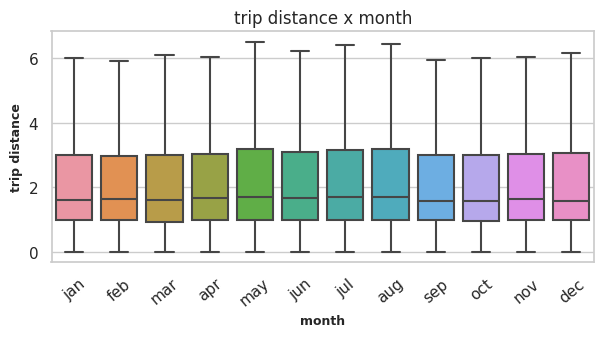

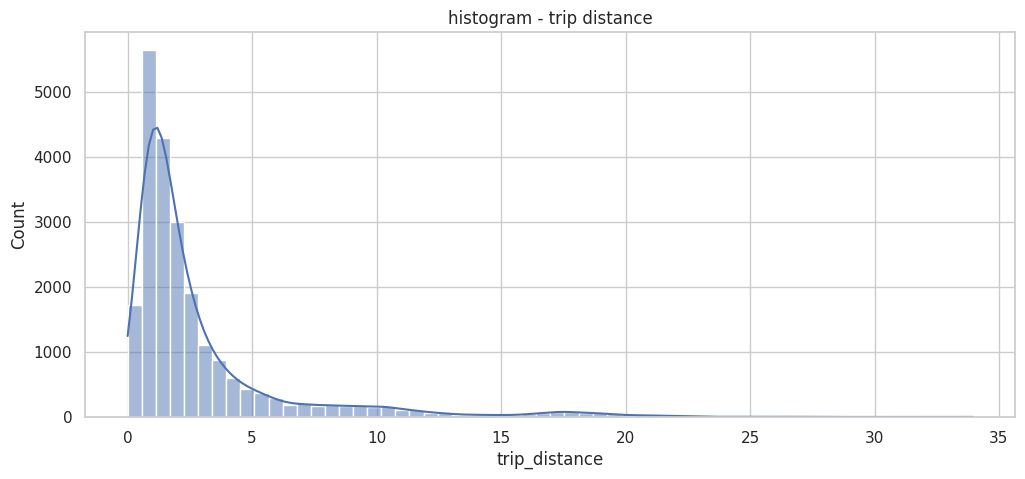

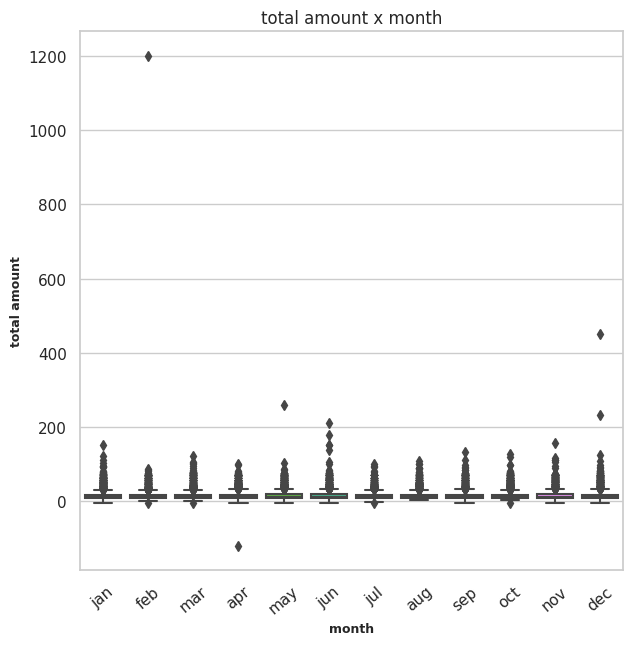

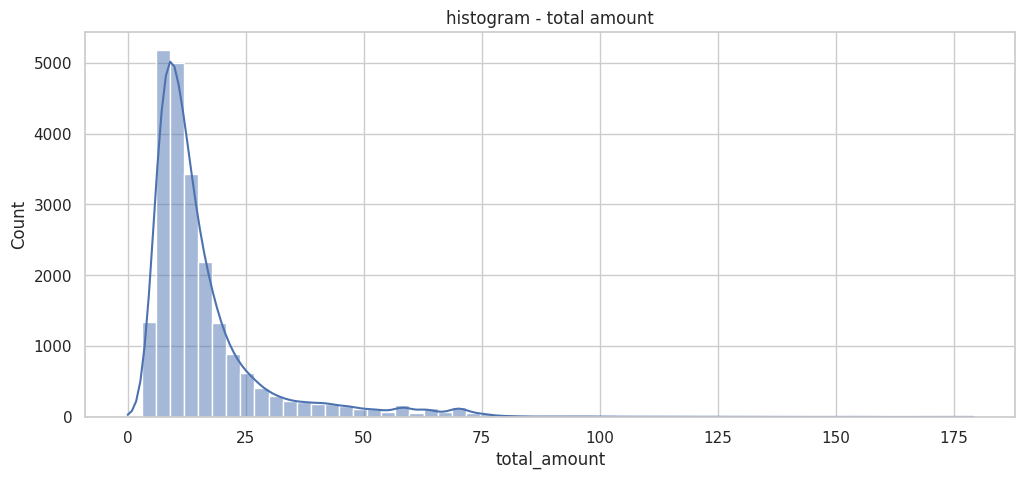

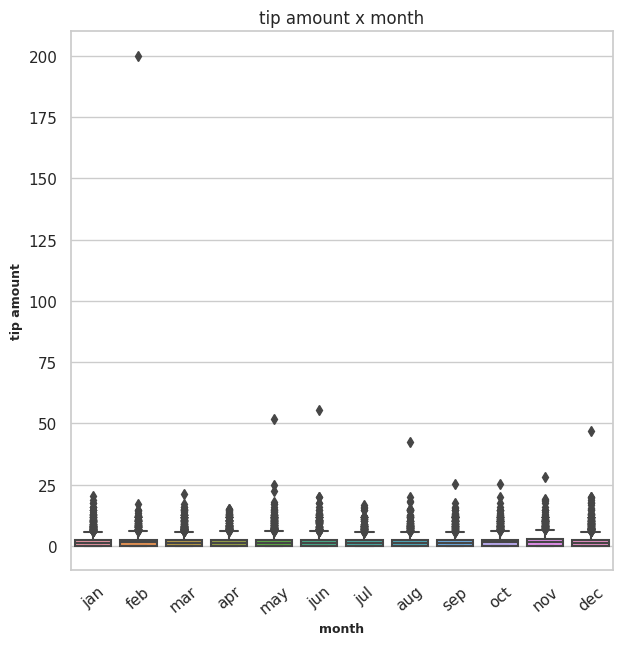

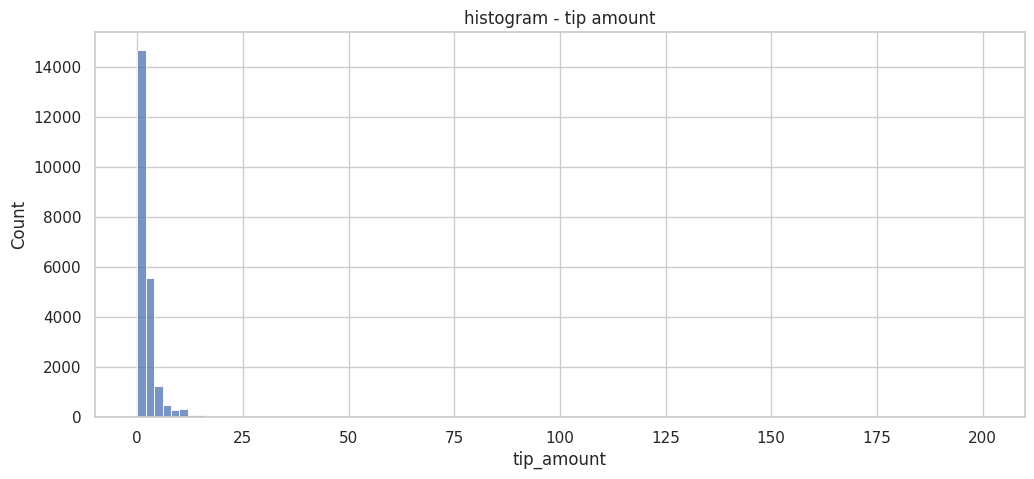

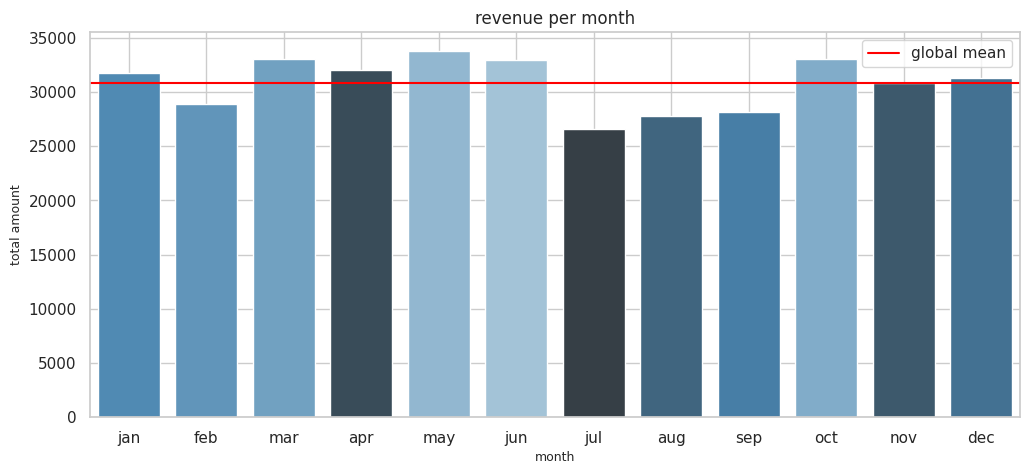

In [30]:
plt.figure(figsize = (7, 3))

sns.boxplot(x = df['month_name'],
            y = df['trip_distance'],
            order = months,
            showfliers = False);

plt.xlabel('month', fontsize = 9, weight = 'bold')
plt.ylabel('trip distance', fontsize = 9, weight = 'bold')
plt.title('trip distance x month', fontsize = 12)
plt.xticks(rotation = 40)

plt.show()

# mask_trip_distance = (df['trip_distance'] <= 4)
# df_mask_trip_distance = df[mask_trip_distance]

plt.figure(figsize = (12, 5))
sns.histplot(data = df,
             x = 'trip_distance',
             bins = 60,
             kde = True)

plt.title('histogram - trip distance', fontsize = 12)
plt.grid(True)

plt.figure(figsize = (7, 7))
sns.boxplot(x = df['month_name'],
            y = df['total_amount'],
            order = months,
            showfliers = True);

plt.xlabel('month', fontsize = 9, weight = 'bold')
plt.ylabel('total amount', fontsize = 9, weight = 'bold')
plt.title('total amount x month', fontsize = 12)
plt.xticks(rotation = 40)

plt.show()

mask_total_amount = ((df['total_amount'] <= 200) & (df['total_amount'] >= 0))
df_mask_total_amount = df[mask_total_amount]

plt.figure(figsize = (12, 5))
sns.histplot(data = df_mask_total_amount,
             x = 'total_amount',
             bins = 60,
             kde = True)

plt.title('histogram - total amount', fontsize = 12)
plt.grid(True)

plt.figure(figsize = (7, 7))
sns.boxplot(x = df['month_name'],
            y = df['tip_amount'],
            order = months,
            showfliers = True)

plt.xlabel('month', fontsize = 9, weight = 'bold')
plt.ylabel('tip amount', fontsize = 9, weight = 'bold')
plt.title('tip amount x month', fontsize = 12)
plt.xticks(rotation = 40)

plt.show()

plt.figure(figsize = (12, 5))
sns.histplot(data = df,
             x = 'tip_amount',
             bins = 100,
             kde = False)

plt.title('histogram - tip amount', fontsize = 12)
plt.grid(True)

plt.figure(figsize = (12, 5))
data = df_group_sum_revenue_month.head(12)
pal = sns.color_palette("Blues_d", len(data))
rank = data['total_amount'].argsort()
ax = sns.barplot(x = data.index,
                 y = data['total_amount'],
                 palette = np.array(pal[::-1])[rank])
ax.axhline(df_group_sum_revenue_month['total_amount'].mean(), ls = '-', color = 'red', label = 'global mean')
ax.legend()
plt.title('revenue per month', fontsize = 12)
plt.xlabel('month', fontsize = 9)
plt.ylabel('total amount', fontsize = 9)
plt.grid(True)

,trip_distance
DOLocationID,
207,1.200000
193,1.390556
237,1.555494
234,1.727806
137,1.818852
...,...
51,17.310000
11,17.945000
210,20.500000


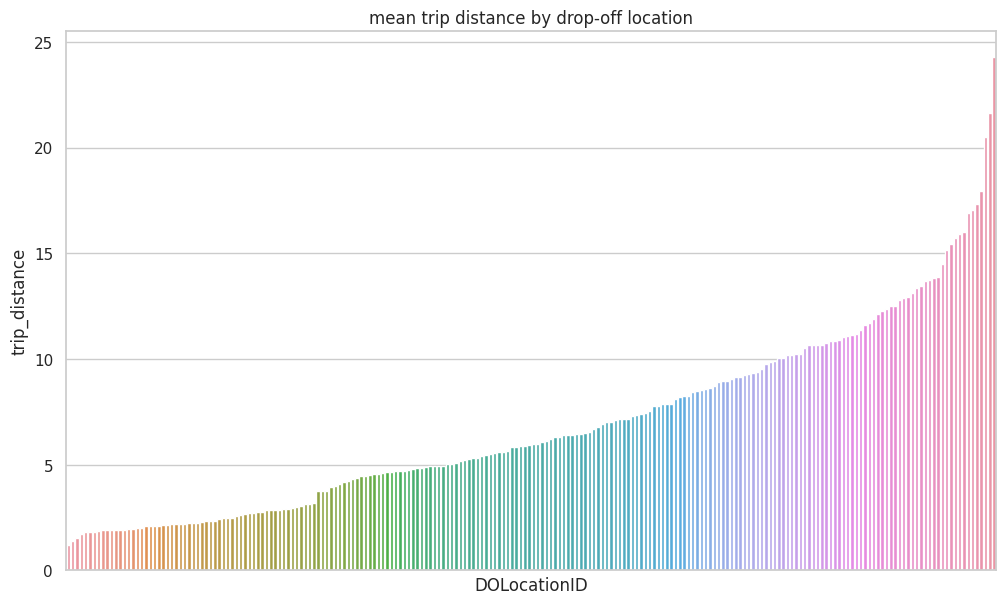

In [31]:
dropoff_mean = df.groupby('DOLocationID')[['trip_distance']].mean()
dropoff_mean = dropoff_mean.sort_values(by = 'trip_distance', ascending = True)
display(dropoff_mean)

plt.figure(figsize = (12, 7))
ax = sns.barplot(x = dropoff_mean.index,
            y = dropoff_mean['trip_distance'],
            order = dropoff_mean.index)
ax.set_xticklabels([])
ax.set_xticks([])
plt.title('mean trip distance by drop-off location', fontsize = 12)
plt.show()

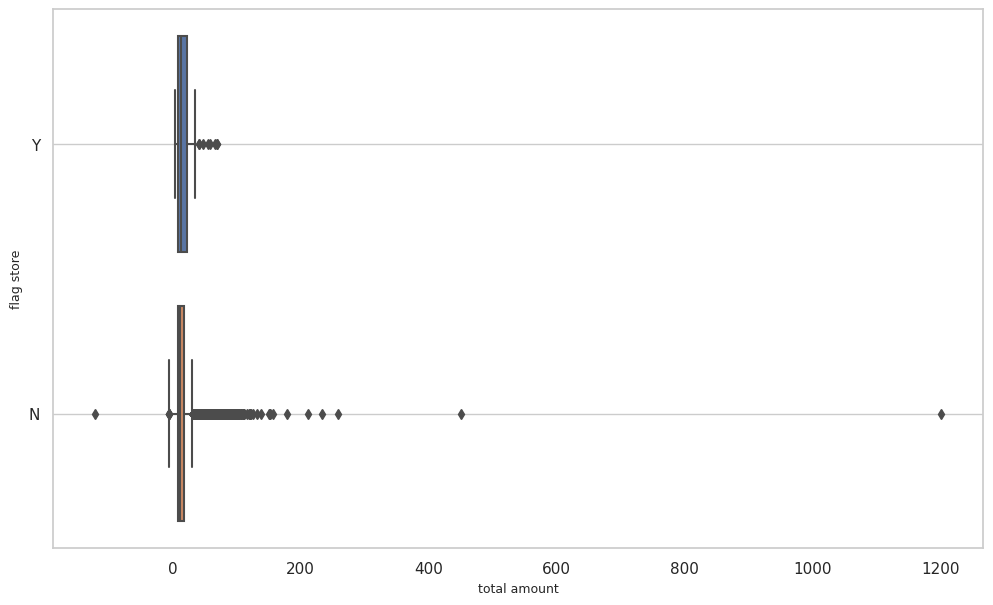

In [32]:
flag_order = ['Y', 'N']

df_sorted_total_amount = df
df_sorted_total_amount['total_amount'] = df_sorted_total_amount['total_amount'].sort_values(ascending = True)
df_sorted_total_amount

plt.figure(figsize = (12, 7))
ax = sns.boxplot(x = df_sorted_total_amount['total_amount'],
                 y = df_sorted_total_amount['store_and_fwd_flag'],
                 order = flag_order)

#ax.set_xticklabels(df_sorted_total_amount['total_amount'], fontsize = 16)
#ax.set_yticklabels(df_sorted_total_amount['store_and_fwd_flag'], fontsize = 16)
plt.xlabel('total amount', fontsize = 9)
plt.ylabel('flag store', fontsize = 9)

plt.grid()

***Pro tip:*** Put yourself in your client's perspective, what would they want to know? 

My client would likely want to know: if the type of outliers come from the way that this data was set up on the datasource, if it was sent with the flag Y or N, which can be a source of data inconsistency.

In [33]:
df['trip_duration'] = ((df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60).round(2) #trip_duration [min]
df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_duration', 'total_amount', 'month_name', 'day_name']]

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_duration,total_amount,month_name,day_name
0,2017-03-25 08:55:43,2017-03-25 09:09:47,14.07,16.56,mar,sat
1,2017-04-11 14:53:28,2017-04-11 15:19:58,26.50,20.80,apr,tue
2,2017-12-15 07:26:56,2017-12-15 07:34:08,7.20,8.75,dec,fri
3,2017-05-07 13:17:59,2017-05-07 13:48:14,30.25,27.69,may,sun
4,2017-04-15 23:32:20,2017-04-15 23:49:03,16.72,17.80,apr,sat
...,...,...,...,...,...,...
22694,2017-02-24 17:37:23,2017-02-24 17:40:39,3.27,5.80,feb,fri
22695,2017-08-06 16:43:59,2017-08-06 17:24:47,40.80,73.20,aug,sun
22696,2017-09-04 14:54:14,2017-09-04 14:58:22,4.13,5.30,sep,mon
22697,2017-07-15 12:56:30,2017-07-15 13:08:26,11.93,13.00,jul,sat


In [34]:
def calculate_iqr_limits(df, column):
    ### Calcula os limites superior e inferior usando IQR para uma coluna específica
    
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr
    return q1, q3, iqr, upper_limit, lower_limit

def view_outliers(df):
    
    numeric_columns = df.select_dtypes(include=['number']).columns
    total_dataset = df.shape[0]
    
    for column in numeric_columns:
        q1, q3, iqr, upper_limit, lower_limit = calculate_iqr_limits(df, column)
        
        df_outliers = df[(df[column] >= upper_limit) | (df[column] <= lower_limit)]
        
        total_outliers = df_outliers.shape[0]
        percentage_outliers = total_outliers / total_dataset
        
        if 0 < percentage_outliers < 1:
            print(f'[ {column} ] >> {total_outliers} outliers ::: {percentage_outliers * 100:.2f}%')
            
view_outliers(df)

[ passenger_count ] >> 2291 outliers ::: 10.09%
[ trip_distance ] >> 2527 outliers ::: 11.13%
[ payment_type ] >> 46 outliers ::: 0.20%
[ fare_amount ] >> 2145 outliers ::: 9.45%
[ extra ] >> 103 outliers ::: 0.45%
[ tip_amount ] >> 1186 outliers ::: 5.22%
[ total_amount ] >> 2161 outliers ::: 9.52%
[ trip_duration ] >> 1228 outliers ::: 5.41%


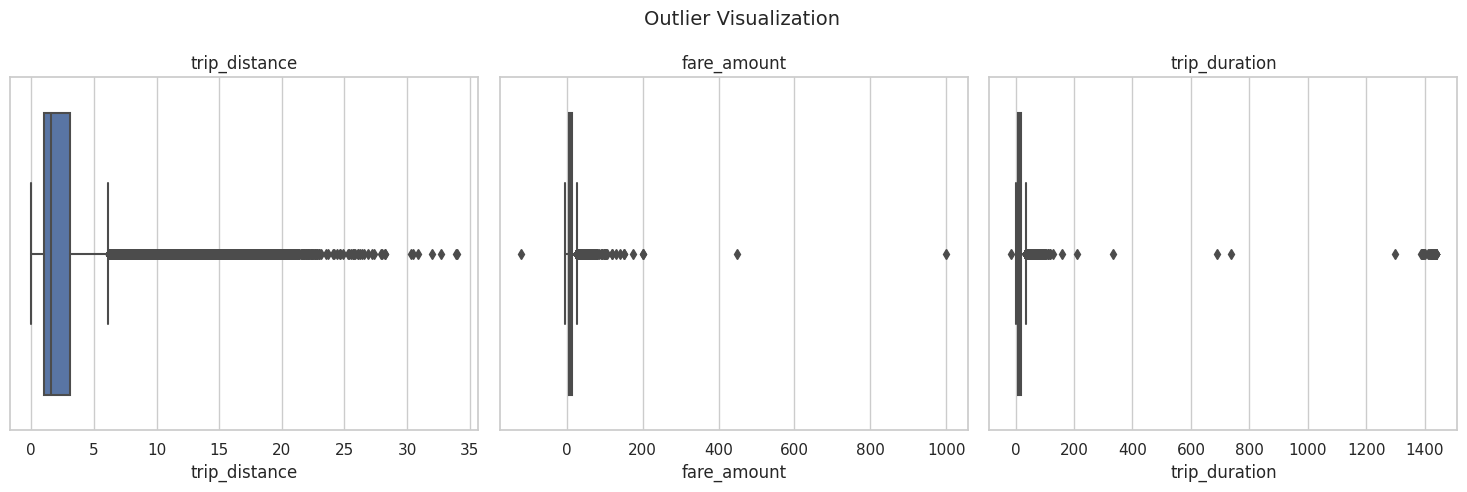

In [35]:
column_list = ['trip_distance', 'fare_amount', 'trip_duration']

fig, axes = plt.subplots(1, 3, figsize = (15, 5))
fig.suptitle('Outlier Visualization', fontsize = 14)

for i, column in enumerate(column_list):
    sns.boxplot(ax = axes[i], x = df[column])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [36]:
def fix_data(df, column, factor_limit):
    
    q1, q3, iqr, upper_limit, lower_limit = calculate_iqr_limits(df, column)
    superior_limit = q3 + factor_limit * iqr # Define um limite superior

    print(f'>> {column} column adjustment')
    print(f'>> Q3: {q3:.2f}')
    print(f'>> IQR: {iqr:.2f}')
    print(f'>> Superior Limit (custom): {superior_limit:.2f}\n')
    
    df.loc[df[column] < 0, column] = 0 # Ajusta valores negativos para 0
    df.loc[df[column] > superior_limit, column] = superior_limit # Ajusta valores que ultrapassam superior_limit
    
    display(df[column].describe())
    print()

for column in column_list:
    fix_data(df = df, column = column, factor_limit = 6)

>> trip_distance column adjustment
>> Q3: 3.06
>> IQR: 2.07
>> Superior Limit (custom): 15.48



count    22699.000000
mean         2.823424
std          3.252029
min          0.000000
25%          0.990000
50%          1.610000
75%          3.060000
max         15.480000
Name: trip_distance, dtype: float64


>> fare_amount column adjustment
>> Q3: 14.50
>> IQR: 8.00
>> Superior Limit (custom): 62.50



count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64


>> trip_duration column adjustment
>> Q3: 18.38
>> IQR: 11.73
>> Superior Limit (custom): 88.76



count    22699.000000
mean        14.460471
std         11.946570
min          0.000000
25%          6.650000
50%         11.180000
75%         18.380000
max         88.760000
Name: trip_duration, dtype: float64

## A/B Test

***down:*** You are interested in the relationship between payment type and the fare amount the customer pays. One approach is to look at the average fare amount for each payment type. 

In [37]:
df_credit = df[df['payment_type'] == 1]
df_cash = df[df['payment_type'] == 2]

mean_credit = df_credit['fare_amount'].mean()
mean_cash = df_cash['fare_amount'].mean()

std_credit = df_credit['fare_amount'].std()
std_cash = df_cash['fare_amount'].std()

print(f'mean fare amount [credit]: {mean_credit:.2f} // mean fare amount [cash]: {mean_cash:.2f}')
print(f'std fare amount [credit]: {std_credit:.2f} // std fare amount [cash]: {std_cash:.2f}')

mean fare amount [credit]: 13.28 // mean fare amount [cash]: 12.11
std fare amount [credit]: 10.67 // std fare amount [cash]: 10.12


Based on the averages shown, it appears that customers who pay in credit card tend to pay a larger fare amount than customers who pay in cash. However, this difference might arise from random sampling, rather than being a true difference in fare amount. To assess whether the difference is statistically significant, we will conduct a hypothesis test.

#### Task 3. Hypothesis testing

Before you conduct the hypothesis test, consider the following questions where applicable to complete:

Recall the difference between the null hypothesis and the alternative hypotheses. Consider the hypotheses for this project as listed below.


$H_0$: There is no difference in the average fare amount between customers who use credit cards and customers who use cash.

$H_A$: There is a difference in the average fare amount between customers who use credit cards and customers who use cash.

In [38]:
statistic, pvalue = stats.ttest_ind(a = df_credit['fare_amount'],
                                    b = df_cash['fare_amount'],
                                    equal_var = False)
print(f'statistic: {statistic:.2f} // pvalue: {pvalue * 100:.2f}%')

statistic: 8.00 // pvalue: 0.00%


The pvalue is significantly smaller than the significance level, then we reject the null hypothesis. Our analysis shows us that there is a significant difference for each payment type. Even if we had chosen 1% for the significance level, the analysis gives support to the rejection of the null hypothesis.

### Feature Engineering

#### Create `mean_distance` and `mean_duration` column

When deployed, the model will not know the duration of a trip until after the trip occurs, so we cannot train a model that uses this feature. However, we can use the statistics of trips we *do* know to generalize about ones we do not know.

In this step, we will create a column called `mean_distance` that captures the mean distance for each group of trips that share pickup and dropoff points.

For example, if your data were:

| Trip   | Start  |  End   |Distance|
|:------:|:------:|:------:|:------:|
|  1     |   A    |   B    |    1   |
|  2     |   C    |   D    |    2   |
|  3     |   A    |   B    |   1.5  |
|  4     |   D    |   C    |    3   |

The results should be:
```
A -> B: 1.25 miles
C -> D: 2 miles
D -> C: 3 miles
```

Then, a new column `mean_distance` will be added where the value at each row is the average for all trips with those pickup and dropoff locations:

| Trip   | Start  |  End   |Distance|mean_distance|
|:------:|:------:|:------:|:------:|:-----------:|
|  1     |   A    |   B    |    1   |   1.25      |
|  2     |   C    |   D    |    2   |    2        |
|  3     |   A    |   B    |   1.5  |   1.25      |
|  4     |   D    |   C    |    3   |    3        |


Begin by creating a helper column called `pickup_dropoff`, which contains the unique combination of pickup and dropoff location IDs for each row.

In [39]:
df['pickup_dropoff'] = df['PULocationID'].astype('str') + ' ' + df['DOLocationID'].astype('str')
df[['pickup_dropoff']].head(3)

,pickup_dropoff
0,100 231
1,186 43
2,262 236


In [40]:
column_list = ['trip_distance', 'trip_duration']

for i, column in enumerate(column_list):
    grouped = df.groupby('pickup_dropoff').mean(numeric_only = True)[[column]].round(4)
        
    grouped_dict = grouped.to_dict()
    grouped_dict = grouped_dict[column]
    
    df['mean_' + column] = df['pickup_dropoff']
    df['mean_' + column] = df['mean_' + column].map(grouped_dict)

print(df[['mean_' + col for col in column_list]])

       mean_trip_distance  mean_trip_duration
0                  3.5217             22.8483
1                  3.1089             24.4700
2                  0.8814              7.2503
3                  3.7000             30.2500
4                  4.4350             14.6200
...                   ...                 ...
22694              1.0982              8.5943
22695             15.4800             59.5600
22696              0.6842              6.6097
22697              2.0775             16.6488
22698              1.4770              9.4048

[22699 rows x 2 columns]


In [41]:
def rush_transformation(row):
    
    condition_wknd = row['day_name'] not in ['sat', 'sun']
    cond_06_10 =  6 <= row['tpep_pickup_datetime'].hour <= 10
    cond_16_20 = 16 <= row['tpep_pickup_datetime'].hour <= 20
    conditions = condition_wknd and (cond_06_10 or cond_16_20)
    
    return int(conditions)

df['rush_hour'] = df.apply(rush_transformation, axis = 1)
df[['day_name', 'tpep_pickup_datetime', 'rush_hour']]

def day_period(row):
    pickup_hour = row['tpep_pickup_datetime'].hour
    if 6 <= pickup_hour < 10:
        return 'am_rush'
    elif 10 <= pickup_hour < 16:
        return 'daytime'
    elif 16 <= pickup_hour < 20:
        return 'pm_rush'
    else:
        return 'nighttime'
        
df['day_period'] = df.apply(day_period, axis = 1)
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,month_num,month_name,day_num,day_name,trip_duration,pickup_dropoff,mean_trip_distance,mean_trip_duration,rush_hour,day_period
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,03,mar,25,sat,14.07,100 231,3.5217,22.8483,0,am_rush
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,04,apr,11,tue,26.50,186 43,3.1089,24.4700,0,daytime
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,12,dec,15,fri,7.20,262 236,0.8814,7.2503,1,am_rush
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,05,may,07,sun,30.25,188 97,3.7000,30.2500,0,daytime
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,04,apr,15,sat,16.72,4 112,4.4350,14.6200,0,nighttime


In [42]:
df_implemented = df[[
    'VendorID', 'passenger_count', 'fare_amount', 'mean_trip_distance',
    'mean_trip_duration','day_name', 'day_period', 'rush_hour']].copy()

df_implemented['VendorID'] = df_implemented['VendorID'].astype(str)
df_implemented = pd.get_dummies(df_implemented, drop_first = False)

X = df_implemented.drop(columns = ['fare_amount'])
y = df_implemented[['fare_amount']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

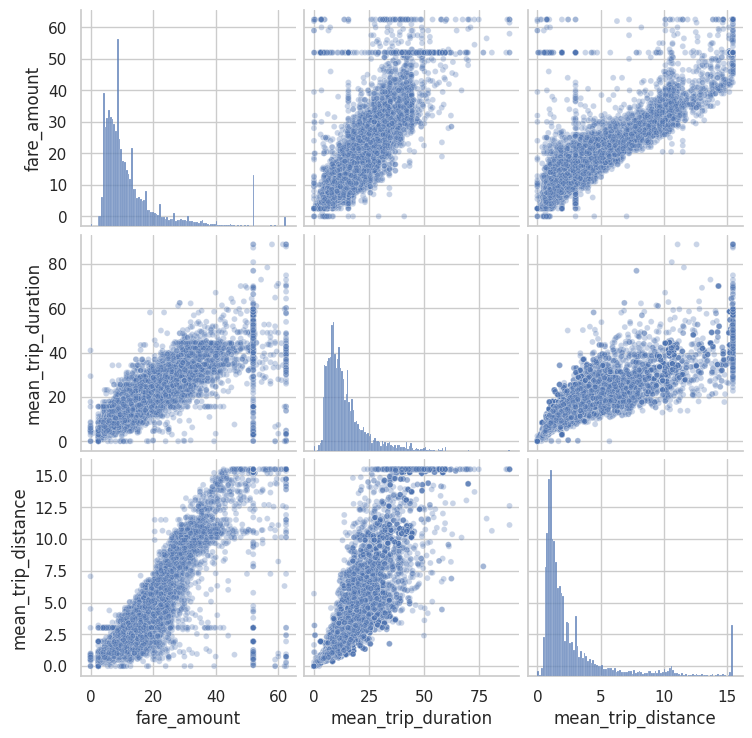

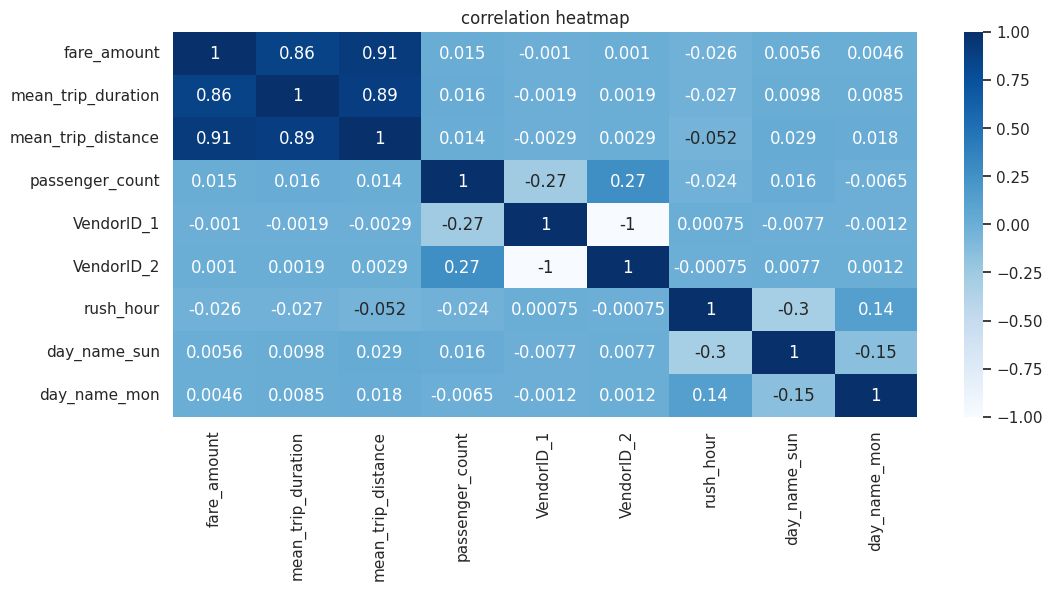

In [43]:
sns.pairplot(df_implemented[['fare_amount', 'mean_trip_duration', 'mean_trip_distance']],
            plot_kws={'alpha': 0.3, 'size': 3});

plt.figure(figsize = (12, 5))
sns.heatmap(df_implemented[[
    'fare_amount', 'mean_trip_duration', 'mean_trip_distance', 'passenger_count',
    'VendorID_1', 'VendorID_2', 'rush_hour', 'day_name_sun', 'day_name_mon'
        ]].corr(method = 'pearson'),
            annot = True,
            cmap = 'Blues')
plt.title('correlation heatmap', fontsize = 12)

plt.show()

`mean_duration` and `mean_distance` are both highly correlated with the target variable of `fare_amount` They're also both correlated with each other, with a Pearson correlation of 0.89.

Recall that highly correlated predictor variables can be bad for linear regression models when you want to be able to draw statistical inferences about the data from the model. However, correlated predictor variables can still be used to create an accurate predictor if the prediction itself is more important than using the model as a tool to learn about your data.

This model will predict `fare_amount`, which will be used as a predictor variable in machine learning models. Therefore, we will try modeling with both variables even though they are correlated.

### Train data

In [44]:
y_pred_train = lr.predict(X_train_scaled)

print('R^2:', r2_score(y_train, y_pred_train))
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

R^2: 0.8425799476535465
MAE: 2.1489452426429803
MSE: 17.584062900458065
RMSE: 4.19333553397031


### Test data

In [45]:
X_test_scaled = scaler.transform(X_test)
y_pred_test = lr.predict(X_test_scaled)

print('R^2:', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

R^2: 0.8754724087721372
MAE: 2.083347092121776
MSE: 13.541951380039611
RMSE: 3.6799390456962207


In [46]:
results = pd.DataFrame(data = {'actual': y_test['fare_amount'],
                               'predicted': y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
5818,14.0,11.528333,2.471667
18134,28.0,17.344739,10.655261
4655,5.5,7.422864,-1.922864
7378,15.5,16.856458,-1.356458
13914,9.5,11.188489,-1.688489


The model performance is high on both training and test sets, suggesting that there is little bias in the model and that the model is not overfit. In fact, the test scores were even better than the training scores.

For the test data, an R<sup>2</sup> of 87.25% of the variance in the `fare_amount` variable is described by the model.

The mean absolute error is informative here because, for the purposes of the model, an error of two is not more than twice as bad as an error of one.

### Visualize model results

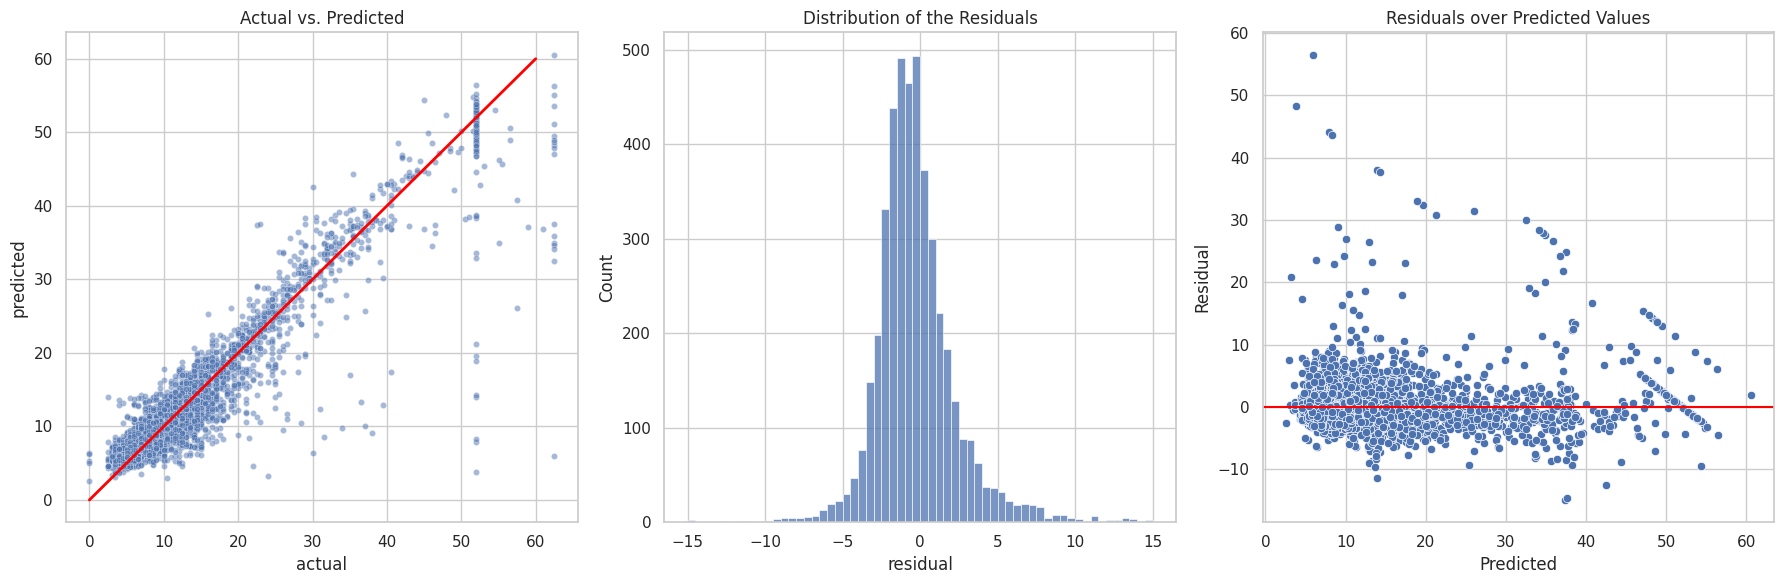

In [47]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))
sns.set(style = 'whitegrid')

# Gráfico 1: actual vs. predicted
sns.scatterplot(
    x = 'actual',
    y = 'predicted',
    data = results,
    s = 20,
    alpha = 0.5,
    ax = axes[0])

axes[0].plot([0, 60], [0, 60], c = 'red', linewidth = 2)
axes[0].set_title('Actual vs. Predicted')

# Gráfico 2: Distribuição dos resíduos
sns.histplot(results['residual'],
             bins = np.arange(-15, 15.5, 0.5),
             ax = axes[1])
axes[1].set_title('Distribution of the Residuals')

# Gráfico 3: Resíduos sobre valores previstos
sns.scatterplot(
    x = 'predicted',
    y = 'residual',
    data = results,
    ax = axes[2]
)
axes[2].axhline(0, c = 'red')
axes[2].set_title('Residuals over Predicted Values')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Residual')

plt.tight_layout()
plt.show()

The distribution of the residuals is approximately normal and has a mean of -0.015. The residuals represent the variance in the outcome variable that is not explained by the model. A normal distribution around zero is good, as it demonstrates that the model's errors are evenly distributed and unbiased.

The model's residuals are evenly distributed above and below zero, with the exception of the sloping lines from the upper-left corner to the lower-right corner, which you know are the imputed maximum of \\$62.50 and the flat rate of \\$52 for JFK airport trips.

In [48]:
coefficients = pd.DataFrame(lr.coef_, columns = X.columns)
coefficients

,passenger_count,mean_trip_distance,mean_trip_duration,rush_hour,VendorID_1,VendorID_2,day_name_fri,day_name_mon,day_name_sat,day_name_sun,day_name_thu,day_name_tue,day_name_wed,day_period_am_rush,day_period_daytime,day_period_nighttime,day_period_pm_rush
0,-0.041459,7.594528,2.310144,0.107768,-4.744659e+13,-4.744659e+13,1.432423e+14,1.342394e+14,1.416796e+14,1.361130e+14,1.422697e+14,1.386073e+14,1.431134e+14,-3.615905e+13,-4.573884e+13,-4.661545e+13,-4.210630e+13


The coefficients reveal that `mean_distance` was the feature with the greatest weight in the model's final prediction. Be careful here! A common misinterpretation is that for every mile traveled, the fare amount increases by a mean of \\$7.57. This is incorrect. Remember, the data used to train the model was standardized with `StandardScaler()`. As such, the units are no longer miles. In other words, we cannot say "for every mile traveled...", as stated above. The correct interpretation of this coefficient is: controlling for other variables, *for every +1 change in standard deviation*, the fare amount increases by a mean of \\$7.57. Note also that because some highly correlated features were not removed, the confidence interval of this assessment is wider.

Translate this back to miles instead of standard deviation (i.e., unscale the data):

1. Calculate the standard deviation of `mean_distance` in the `X_train` data.
2. Divide the coefficient by the result to yield a more intuitive interpretation.

In [49]:
# ## 1. Calculate SD of `mean_distance` in X_train data
# ## 2. Divide the model coefficient by the standard deviation
value1 = coefficients['mean_trip_distance']
value2 = (coefficients['mean_trip_distance'] / X_train['mean_trip_distance'].std())

print(f">> the fare increased by a mean of ${value1.item():.2f} for every {X_train['mean_trip_distance'].std():.2f} miles traveled")
print(f">> and by a mean of ${value2.item():.2f} for every 1 mile traveled")

>> the fare increased by a mean of $7.59 for every 3.19 miles traveled
>> and by a mean of $2.38 for every 1 mile traveled


### Predict on full dataset
Save final predictions with `mean_duration` and `mean_distance` columns

In [50]:
X_scaled = scaler.transform(X)
y_preds = lr.predict(X_scaled)

yellow_taxi_preds = df[['mean_trip_duration', 'mean_trip_distance']].copy()
yellow_taxi_preds['predicted_fare'] = y_preds

df['predicted_fare'] = y_preds
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,month_num,month_name,day_num,day_name,trip_duration,pickup_dropoff,mean_trip_distance,mean_trip_duration,rush_hour,day_period,predicted_fare
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,03,mar,25,sat,14.07,100 231,3.5217,22.8483,0,am_rush,15.922864
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,04,apr,11,tue,26.50,186 43,3.1089,24.4700,0,daytime,16.844739
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,12,dec,15,fri,7.20,262 236,0.8814,7.2503,1,am_rush,6.860364
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,05,may,07,sun,30.25,188 97,3.7000,30.2500,0,daytime,18.610364
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,04,apr,15,sat,16.72,4 112,4.4350,14.6200,0,nighttime,16.028333


In [52]:
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'trip_duration', 'PULocationID', 'DOLocationID',
             'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'store_and_fwd_flag',
             'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'improvement_surcharge', 'total_amount', 'month_name', 'month_num', 'day_num', 'predicted_fare']

df1 = df.drop(drop_cols, axis = 1)

cols_to_str = ['RatecodeID', 'VendorID']

for col in cols_to_str:
    df[col] = df[col].astype('str')

In [53]:
df1 = pd.get_dummies(df1, drop_first = False)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Columns: 4196 entries, passenger_count to day_period_pm_rush
dtypes: bool(4191), float64(3), int64(2)
memory usage: 91.6 MB


In [54]:
features = df1.drop('fare_amount', axis = 1)
target = df1['fare_amount']

# Split the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.20,
    random_state=42
)

# Standardize features using Z-score normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
%%time
# ##  6. Model Definitions and Hyperparameter Grids

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize models with relevant configurations
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(
        objective='reg:squarederror',
        use_label_encoder=False,
        random_state=42
    )
}

# Define hyperparameter grids for each model
param_grids = {
    'Decision Tree': {
        'max_depth': [1, 4, None],
        'min_samples_leaf': [2, 5, 10],
        'min_samples_split': [2, 10]
    },
    'Random Forest': {
        'max_depth': [1, 4, None],
        'min_samples_leaf': [2, 5, 10],
        'min_samples_split': [2, 10],
        'max_features': [0.5, 1.0],
        'max_samples': [0.7, 1.0],
        'n_estimators': [50, 200]
    },
    'XGBoost': {
        'max_depth': [1, 4, 6],
        'subsample': [0.5, 1.0],
        'min_child_weight': [2, 5],
        'learning_rate': [0.1, 0.2],
        'n_estimators': [50, 200]
    }
}

CPU times: user 129 µs, sys: 0 ns, total: 129 µs
Wall time: 134 µs


In [57]:
%%time
# ##  7. Training and Hyperparameter Optimization

best_models = {}

for name, model in models.items():
    if name in param_grids:
        # Perform grid search with cross-validation
        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            scoring='r2',
            cv=cv,
            n_jobs=-1,
            verbose=0
        )
        grid.fit(X_train_scaled, y_train)
        best_models[name] = grid.best_estimator_
        print(f"{name} best parameters: {grid.best_params_}\n")
    else:
        # Train model directly without tuning
        model.fit(X_train_scaled, y_train)
        best_models[name] = model

Decision Tree best parameters: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}



KeyboardInterrupt: 